In [16]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
sns.set()

In [17]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
MedianLogical = np.load("MedianLogical.npy")
print(OptimalXAI, MedianLogical)
print(CorrMatrices[:, MedianLogical].shape)

[[ 0 27]
 [ 1  8]
 [ 2 36]
 [ 3 35]
 [ 4 12]
 [ 5 21]
 [ 6  0]
 [ 7  1]] [False  True False False False False  True  True False False False False
 False  True False False False False False False False  True False False
 False False False False False False False False False False False False
  True False  True  True False False False False False]
(5251, 8)


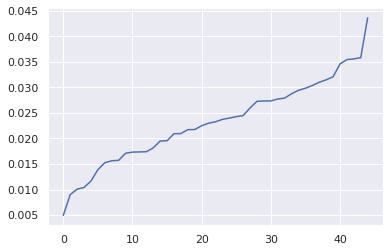

In [18]:
#plt.plot(np.sort(abs(XAI).mean(0)))
plt.plot(np.sort(np.median(abs(XAI),0)))

### Train NN with all relevant features

For this, we need one-hot encoded y

In [19]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{0, 1, 35, 36, 8, 12, 21, 27}
(5251, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


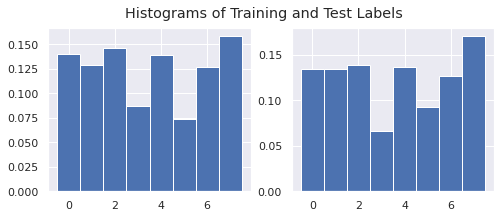

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [21]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

8 8
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               2304      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1024)              132096    
                                                                 
 dense_16 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 8)            

In [22]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 0s 11ms/step - loss: 2.0362 - accuracy: 0.2518 - val_loss: 1.9953 - val_accuracy: 0.2598
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 1.9483 - accuracy: 0.2723 - val_loss: 1.8981 - val_accuracy: 0.2882
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 1.8311 - accuracy: 0.3150 - val_loss: 1.7680 - val_accuracy: 0.3491
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 1.6919 - accuracy: 0.3906 - val_loss: 1.6063 - val_accuracy: 0.4366
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 1.5360 - accuracy: 0.4690 - val_loss: 1.4286 - val_accuracy: 0.5009
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 1.3609 - accuracy: 0.5327 - val_loss: 1.2508 - val_accuracy: 0.5651
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 1.2149 - accuracy: 0.5731 - val_loss: 1.1042 - val_accuracy: 0.6180
Epoch 8/100


In [23]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.8147720715522215


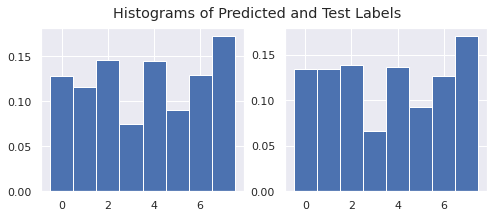

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Comparison: best features according to Median XAI values

In [25]:


X_train, X_test, y_train, y_test = train_test_split(CorrMatrices[:, MedianLogical],
                                                    encoded_Y, test_size=0.33, random_state=1)


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestMedianXAI = np.mean(y_hat == np.argmax(y_test,1))


Epoch 1/100
14/14 [==============================] - 0s 6ms/step - loss: 2.0857 - accuracy: 0.4486 - val_loss: 1.4681 - val_accuracy: 0.5173
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 1.2728 - accuracy: 0.5691 - val_loss: 1.0747 - val_accuracy: 0.6100
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0291 - accuracy: 0.6384 - val_loss: 0.9478 - val_accuracy: 0.6617
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.9233 - accuracy: 0.6765 - val_loss: 0.8670 - val_accuracy: 0.6941
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8445 - accuracy: 0.6970 - val_loss: 0.8124 - val_accuracy: 0.7061
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8017 - accuracy: 0.7072 - val_loss: 0.7747 - val_accuracy: 0.7322
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.7690 - accuracy: 0.7180 - val_loss: 0.7435 - val_accuracy: 0.7374
Epoch 8/100
1

In [26]:
print(Accuracy_BestMedianXAI)

0.8447778418926717


### Now with some other features

In [27]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [28]:
def ModeModeNN(seed = 1234):
    np.random.seed(seed)
    CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [29]:
def MedianNN(seed = 1234):
    np.random.seed(seed)
    CM_Reduced = CorrMatrices[:, MedianLogical]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [30]:
ModeModeNN(53473)

0.8672821696480092

In [31]:
MedianNN(23757)

0.8724754760530872

In [32]:
TestNN(54321)

0.875937680323139

In [33]:
TestNN()

0.847663012117715

In [34]:
Runs = 100
NN_comparison = np.zeros(Runs)
NN_modemode = np.zeros(Runs)
NN_median = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    Mode_Score = ModeModeNN(s)
    Median_Score = MedianNN(s)
    print(i,s,Test_Score,Mode_Score, Median_Score)
    NN_comparison[i] = Test_Score
    NN_modemode[i] = Mode_Score
    NN_median[i] = Median_Score


0 [9047] 0.8557414887478362 0.8799769186381996 0.8834391229082516
1 [2491] 0.825735718407386 0.8949798038084247 0.8845931909982689
2 [3603] 0.8834391229082516 0.8949798038084247 0.8880553952683208
3 [3761] 0.827466820542412 0.8967109059434507 0.8909405654933641
4 [4929] 0.877668782458165 0.9013271783035199 0.896133871898442
5 [3474] 0.8482400461627236 0.8990190421234853 0.8892094633583382
6 [4372] 0.8742065781881131 0.8990190421234853 0.875937680323139
7 [4580] 0.8528563185227929 0.894402769763416 0.8984420080784766
8 [6432] 0.8586266589728794 0.897864974033468 0.8955568378534333
9 [3840] 0.8597807270628968 0.8995960761684939 0.8903635314483554
10 [3716] 0.8822850548182343 0.8995960761684939 0.8869013271783035
11 [2515] 0.8678592036930178 0.896133871898442 0.8851702250432776
12 [1974] 0.8620888632429313 0.9042123485285631 0.8932487016733988
13 [9435] 0.8534333525678015 0.9065204847085978 0.8903635314483554
14 [2556] 0.8747836122331217 0.897864974033468 0.8863242931332949
15 [4042] 0.86

In [35]:
len(NN_modemode), len(NN_comparison), len(NN_median)

(100, 100, 100)

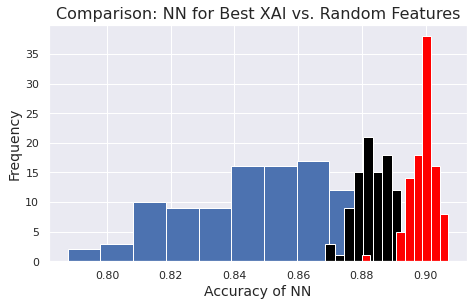

In [36]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
plt.hist(NN_comparison)
plt.hist(NN_median, color="black")
plt.hist(NN_modemode, color="red", bins=10)
#plt.axvline(Accuracy_BestXAI, c="red")
#plt.axvline(Accuracy_BestMedianXAI,  c="black")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
#plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NNs",dpi=600)
plt.show()

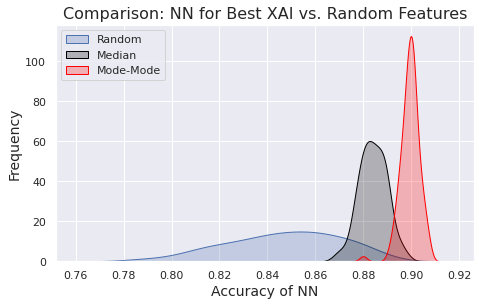

In [37]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
sns.kdeplot(NN_comparison, label ="Random", fill=True)
sns.kdeplot(NN_median, color = "black", label="Median",fill=True)
sns.kdeplot(NN_modemode, color = "red", label="Mode-Mode",fill=True)
plt.legend(loc="upper left")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.savefig("Comparison_100NNs_kde.pdf",dpi=600)
plt.show()

In [59]:
print(np.mean(NN_median), np.std(NN_median),np.mean(NN_median)+ np.std(NN_median) )
print(np.mean(NN_modemode), np.std(NN_modemode),np.mean(NN_modemode)- np.std(NN_modemode) )
print(np.mean(NN_comparison),np.mean(NN_comparison) + np.std(NN_comparison) )


0.8840103866128101 0.005750395420629598 0.8897607820334397
0.8994171956145413 0.003909970937086996 0.8955072246774542
0.8469417195614541 0.8703189882384117


In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               2304      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1024)              132096    
                                                                 
 dense_16 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 8)                

### Additional Benchmark
Compare it to a NN that only selects features that DO NOT belong to the top eight mode-mode features.

In [51]:

LeftoverFeatures = set(range(XAI.shape[1])) - set(OptimalXAI[:,1])
LeftoverFeatures = np.array(list(LeftoverFeatures)).astype("int")
print(LeftoverFeatures)
len(LeftoverFeatures)

[ 2  3  4  5  6  7  9 10 11 13 14 15 16 17 18 19 20 22 23 24 25 26 28 29
 30 31 32 33 34 37 38 39 40 41 42 43 44]


37

In [52]:
def TestNN_Bad(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(LeftoverFeatures, # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [55]:
NN_Leftovers = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Leftover_Score = TestNN_Bad(s)
    NN_Leftovers[i] = Leftover_Score
    print(i, Leftover_Score)

0 0.8003462204270052
1 0.8251586843623774
2 0.8499711482977496
3 0.8540103866128101
4 0.812463935372187
5 0.8020773225620311
6 0.7997691863819966
7 0.8349682631275245
8 0.8430467397576457
9 0.8130409694171956
10 0.8141950375072129
11 0.809001731102135
12 0.8372763993075591
13 0.7841892671667628
14 0.795729948066936
15 0.7888055395268321
16 0.8107328332371609
17 0.7663012117714946
18 0.8280438545874207
19 0.8320830929024813
20 0.8211194460473168
21 0.760530871321408
22 0.7997691863819966
23 0.8038084246970572
24 0.8049624927870744
25 0.8020773225620311
26 0.827466820542412
27 0.7628390075014426
28 0.790536641661858
29 0.8361223312175419
30 0.8066935949221004
31 0.8401615695326025
32 0.8332371609924986
33 0.7443739180611656
34 0.8182342758222735
35 0.7657241777264858
36 0.7224466243508367
37 0.7888055395268321
38 0.7720715522215811
39 0.7316791690709752
40 0.7541834968263128
41 0.7801500288517023
42 0.8153491055972303
43 0.7593768032313907
44 0.8188113098672821
45 0.7518753606462781
46 0

In [58]:
np.mean(NN_Leftovers)

0.7864685516445471

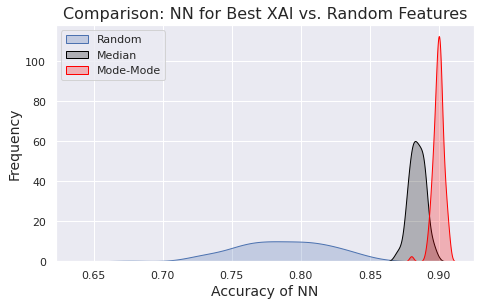

In [62]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
sns.kdeplot(NN_Leftovers, label ="Random", fill=True)
sns.kdeplot(NN_median, color = "black", label="Median",fill=True)
sns.kdeplot(NN_modemode, color = "red", label="Mode-Mode",fill=True)
#sns.kdeplot(NN_Leftovers, color = "green", label = "Only Suboptimal", fill = True)
plt.legend(loc="upper left")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.savefig("Comparison_100NNs_kde_withLeftovers.pdf",dpi=600)
plt.show()